In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import time 
from tqdm import tqdm
import pandas as pd

In [4]:
from numba import njit

In [5]:
def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(loc=0.0, scale=1.0, size=M))
    
    return S

In [6]:
def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

In [7]:
def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2), norm.cdf(d1)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1), -norm.cdf(-d1)

In [8]:
S0 = 50                                 # Initial stock price
K = 50                                  # Strike price
mu = 0.06                               # Risk free rate
sigma = 0.2                             # Volatility
T = 1                                   # Time to maturity
N = 4                                   # Number of monitoring dates
M = 5000                                # Number of sample paths

In [9]:
black_scholes(S0, K, mu, sigma, T, option_type='put')

(np.float64(2.5830012555254314), np.float64(-0.3445782583896758))

In [10]:
def binomial_option_pricing(S, K, T, r, sigma, N, monitoring_dates, option_type='call'):
    dt = T / N  # Length of each time interval
    u = np.exp(sigma * np.sqrt(dt))  # Up factor
    d = 1 / u  # Down factor
    q = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Initialize arrays to store stock prices and option values
    stock_prices = np.zeros((N+1, N+1))
    option_values = np.zeros((N+1, N+1))

    # Initialize stock prices at maturity
    for i in range(N+1):
        for j in range(i+1):
            stock_prices[i, j] = S * (u**j) * (d**(i-j))

    # Calculate payoff at maturity
    if option_type == 'call':
        option_values[N, :] = np.maximum(stock_prices[N, :] - K, 0)
    else:  # put
        option_values[N, :] = np.maximum(K - stock_prices[N, :], 0)

    # Backward recursion for option price
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            if i*dt in monitoring_dates:
                continuation_value = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
                if option_type == 'call':
                    option_values[i, j] = np.maximum(stock_prices[i, j] - K, continuation_value)
                else:
                    option_values[i, j] = np.maximum(K - stock_prices[i, j], continuation_value)
            else:
                option_values[i, j] = (q * option_values[i+1, j+1] + (1-q) * option_values[i+1, j]) * np.exp(-r * dt)
    delta = (option_values[1, 1] - option_values[1, 0])/(stock_prices[1, 1] - stock_prices[1, 0])

    return option_values[0,0], delta#, stock_prices

In [11]:
binomial_option_pricing(S0, K, T, mu, sigma, 100, [0,0.25, 0.5, 0.75, 1], option_type='put')

(np.float64(2.81889159146015), np.float64(-0.3971209544812329))

In [12]:
def calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M = 10000):
    hedge_error = np.zeros(M)
    for m in tqdm(range(M)):
        V0, delta = binomial_option_pricing(S0, K, T, mu, sigma, 100, monitoring_dates, option_type='put')
        #print(f'Price of the option: {V0}', f'Delta: {delta}')
        cash_flow = V0 - delta * S0
        No_of_shares = delta
        updated_monitoring_dates = monitoring_dates
        #print(f'Initial cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
        S = stock_price_simulator(S0, mu, sigma, T, hedge_freq, 1).flatten()
        #print(S)
        dt = T/hedge_freq
        #print("time stpes in hedging dates", dt)
        for i in range(1, len(hedging_dates)- 1):
            #print(f'Hedging date: {i*dt}')
            updated_monitoring_dates = updated_monitoring_dates - dt
            updated_monitoring_dates = updated_monitoring_dates[updated_monitoring_dates > 0]    
            #print(f'Updated monitoring dates: {updated_monitoring_dates}')
            V1, delta2 = binomial_option_pricing(S[i], K, updated_monitoring_dates[-1], mu, sigma, 100, updated_monitoring_dates, option_type='put')
            if i*dt in monitoring_dates:
                #print("inside", i*dt)
                #print(f'Price of stock: {S[i]}', f'Price of the option: {V1}', f'K: {K}', f'payoff : {payoff_fun(S[i], K, "put")}')
                if payoff_fun(S[i], K, 'put') > V1:
                    #print("Exercise")
                    break
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print(f'Cash flow: {cash_flow}', f'Number of shares to buy: {No_of_shares}')
            else:
                cash_flow = cash_flow * np.exp(mu*dt) - (delta2 - No_of_shares) * S[i]
                No_of_shares = delta2
                #print("Not in monitoring date")
            #print("i", i, No_of_shares)
        if i == len(hedging_dates)-2:
            #print("Last date", i)
            payoff_last = payoff_fun(S[i+1], K, 'put')   
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i+1]
        else:
            #print("i at end", i)
            payoff_last = payoff_fun(S[i], K, 'put')
            final_cash_flow = cash_flow * np.exp(mu*dt) + No_of_shares * S[i]
        #print(f'Final Hedge Error: {payoff_last - final_cash_flow}')
        hedge_error[m] = payoff_last - final_cash_flow
        
    return hedge_error

In [13]:
S0 = 50
K = 50
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 5000
hedging_error = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)


  0%|          | 0/5000 [00:00<?, ?it/s]

  3%|▎         | 172/5000 [02:30<1:10:24,  1.14it/s]


KeyboardInterrupt: 

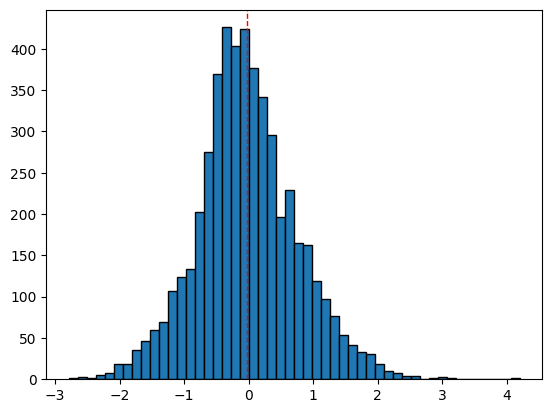

In [ ]:
hedging_error = np.array(hedging_error)
plt.hist(hedging_error, bins=50, edgecolor='black')
plt.axvline(hedging_error.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

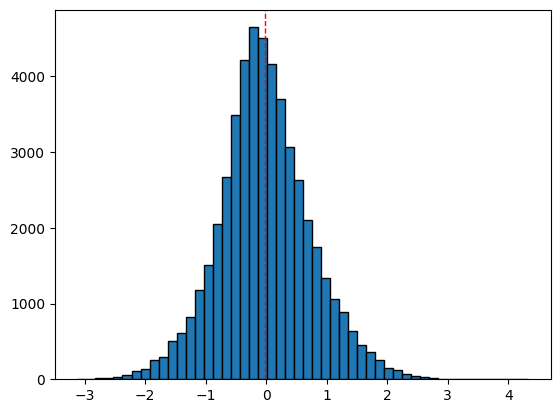

In [ ]:
## Using Numba with 50000 simulations and hedge frequency of 24
hedging_error = np.array(hedging_error)
plt.hist(hedging_error, bins=50, edgecolor='black')
plt.axvline(hedging_error.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
S0 = 50
K = 1.2 * S0
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 20000
hedging_error_120 = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)


100%|██████████| 20000/20000 [31:21<00:00, 10.63it/s]


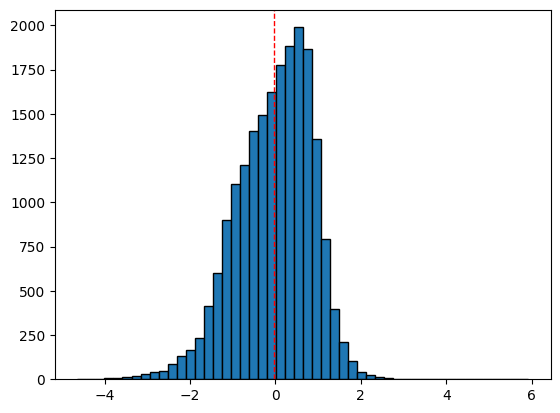

In [ ]:
plt.hist(hedging_error_120, bins=50, edgecolor='black')
plt.axvline(hedging_error_120.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

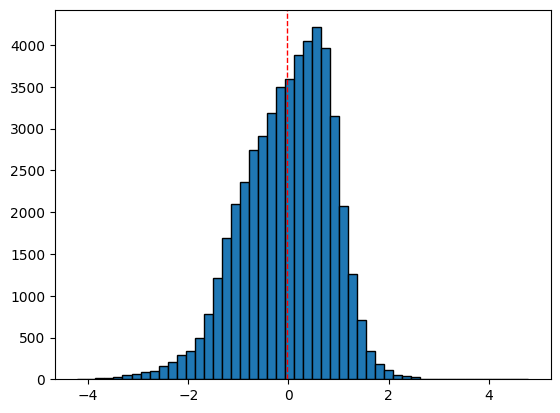

In [ ]:
## Using Numba with 50000 simulations and hedge frequency of 24
plt.hist(hedging_error_120, bins=50, edgecolor='black')
plt.axvline(hedging_error_120.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
S0 = 50
K = 0.8 * S0
mu = 0.06
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
M = 5000
hedging_error_80 = calculate_hedge_error(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates, M)

100%|██████████| 5000/5000 [18:17<00:00,  4.55it/s]


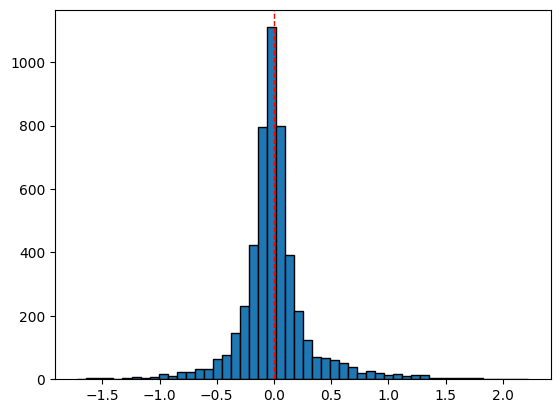

In [ ]:
plt.hist(hedging_error_80, bins=50, edgecolor='black')
plt.axvline(hedging_error_80.mean(), color='r', linestyle='dashed', linewidth=1)
plt.show()

In [ ]:
## Using Numba with 50000 simulations and Hedging frequency of 24
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.savefig('Hedge_error_freq24_sample5000.jpeg')
plt.show()

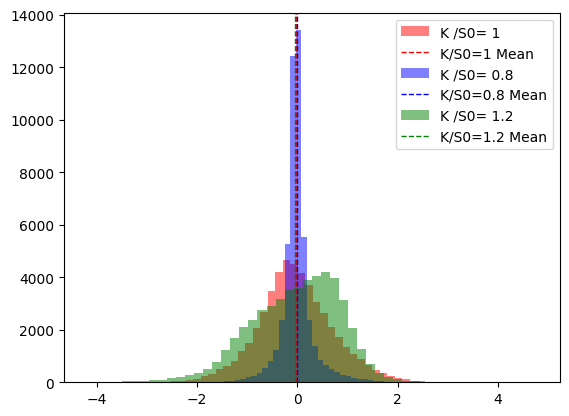

In [ ]:
## Using Numba with 50000 simulations and Hedging frequency of 24
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.show()

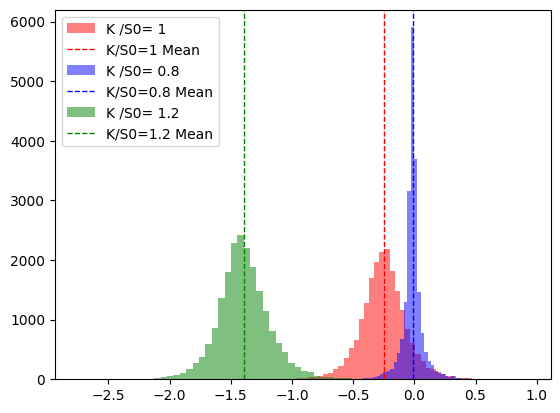

In [ ]:
plt.hist(hedging_error, bins=50, label='K /S0= 1', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error), color='r', linestyle='dashed', linewidth=1, label='K/S0=1 Mean')
plt.hist(hedging_error_80, bins=50, label='K /S0= 0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label='K/S0=0.8 Mean')
plt.hist(hedging_error_120, bins=50, label='K /S0= 1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label='K/S0=1.2 Mean')
plt.legend()
plt.show()

#### Parallel Version

In [ ]:
from multiprocessing import Pool
from tqdm import tqdm
from simulations import run_simulation  # Import the simulation function

In [ ]:
import os

In [ ]:
os.cpu_count()

11

In [ ]:
def main_parallel(num_simulations, S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates):
    params = [(S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates) for _ in range(num_simulations)]
    # Utilize all available CPU cores
    num_cores = os.cpu_count()
    with Pool(num_cores) as pool:
        results = list(tqdm(pool.imap(run_simulation, params), total=num_simulations))
    return results


In [ ]:
hedge_errors = np.array(hedge_errors)
np.mean(hedge_errors), np.std(hedge_errors)

(-0.20070974833217337, 0.1867082667124075)

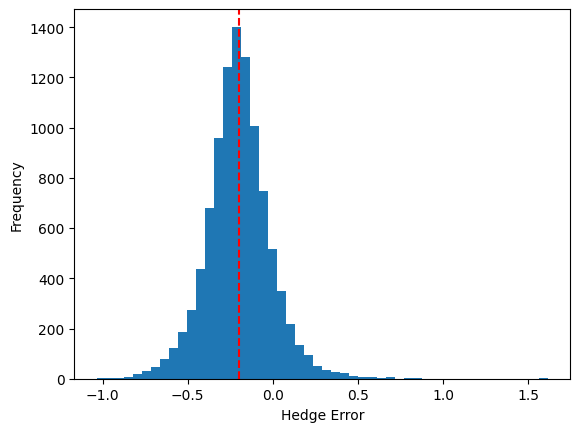

In [ ]:
plt.hist(hedge_errors, bins=50)
plt.axvline(np.mean(hedge_errors), color='red', linestyle='--')
plt.xlabel('Hedge Error')
plt.ylabel('Frequency')
plt.show()

In [ ]:
## 80% of the strike price In the money Option K/S0 = 0.8
if __name__ == '__main__':
    S0 =40
    K = 0.8*S0
    T = 1
    mu = 0.06
    sigma = 0.2
    num_simulations = 1000
    hedge_freq = 252
    monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    hedge_errors_80 = main_parallel(num_simulations, S0, K, mu, sigma, T, hedge_freq, monitoring_dates, hedging_dates)
    print("Simulation completed.")

100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]

Simulation completed.


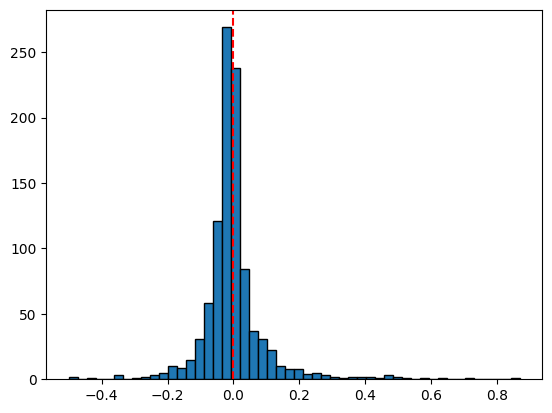

In [ ]:
plt.hist(hedge_errors_80, bins=50, edgecolor='black')
plt.axvline(np.mean(hedge_errors_80), color='red', linestyle='--')
plt.show()

In [ ]:
## 120% of the strike price Out of the money Option K/S0 = 1.2
if __name__ == '__main__':
    S0 =40
    K = 1.2*S0
    T = 1
    mu = 0.06
    sigma = 0.2
    hedge_freq = 52
    monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    num_simulations = 1000
    hedge_errors_120 = main_parallel(num_simulations, S0, K, T, mu, sigma, hedge_freq, monitoring_dates, hedging_dates)
    print("Simulation completed.")

100%|██████████| 1000/1000 [01:08<00:00, 14.65it/s]

Simulation completed.


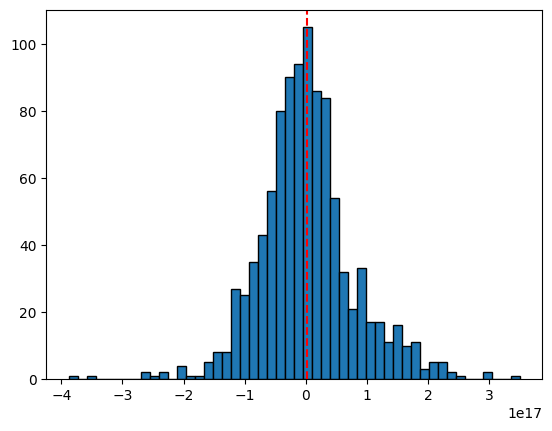

In [ ]:
plt.hist(hedge_errors_120, bins=50, edgecolor='black')
plt.axvline(np.mean(hedge_errors_120), color='red', linestyle='--')
plt.show()

In [ ]:
### 100% of the Strike Price At the money option K/S0 = 1
if __name__ == '__main__':
    S0 =40
    K = S0
    T = 1
    mu = 0.06
    sigma = 0.2
    num_simulations = 10000
    hedge_errors = main_parallel(num_simulations, S0, K, T, mu, sigma)
    print("Simulation completed.")

100%|██████████| 5000/5000 [05:41<00:00, 14.66it/s]

Simulation completed.


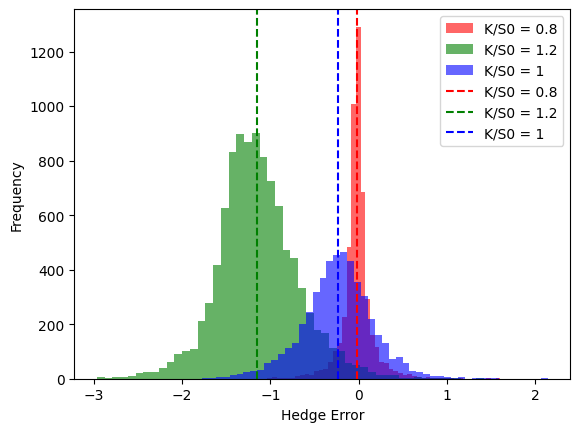

In [ ]:
hedge_errors_80 = np.array(hedge_errors_80)
hedge_errors_120 = np.array(hedge_errors_120)
hedge_errors = np.array(hedge_errors)
plt.hist(hedge_errors_80, bins=50, label='K/S0 = 0.8', color='red', alpha = 0.6)
plt.hist(hedge_errors_120, bins=50, label='K/S0 = 1.2', color='green', alpha = 0.6)
plt.hist(hedge_errors, bins=50, label='K/S0 = 1', color='blue', alpha = 0.6)
plt.axvline(np.mean(hedge_errors_80), linestyle='--', label="K/S0 = 0.8", color='red')
plt.axvline(np.mean(hedge_errors_120), linestyle='--', label='K/S0 = 1.2', color='green')
plt.axvline(np.mean(hedge_errors), linestyle='--', label='K/S0 = 1', color='blue')
plt.xlabel('Hedge Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# RLNN

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split
import time 
from tqdm import tqdm

In [10]:
def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    """
    Args:
        S0 (): Initial stock price
        K (_type_): Stirke price
        r (_type_): risk free rate
        vol (_type_): volatility
        sample_size (_type_): number of samples to generate
        no_mon (_type_): Number of monitoring dates
        style (_type_): option type
        no_hidden_units (_type_): number of hidden units in the neural network
    """
    
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    ## Initialize the option price matrix
    option_price = np.zeros(stock_paths.shape)
    ## Calculate the option price at the maturity date
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    ##Pre Training the neural network
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1), epochs=1000, batch_size=int(0.1 * sample_size), verbose=0)
    ## Pre Training completed   
    X = stock_paths[:, N].reshape(-1, 1)
    ## Normalize the stock prices
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    ## X_train and y_train for the neural network
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    model = create_shallow_NN(1, no_hidden_units)
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    ## Train the model  
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose = 0)
    
    # Test the model
    y_hat_val = model.predict(X_test)
    errors.append(np.mean((y_test - y_hat_val)**2)) ## Store the errors for Last monitoring date
    #plt.scatter(X_train, y_train, label='Actual')
    # Sort X_train and y_hat for a smoother line plot
    #sorted_indices = np.argsort(X_train[:, 0])  # Sort based on the first (and only) feature
    #X_train_sorted = X_train[sorted_indices]
    #y_hat_sorted = y_hat_val[sorted_indices]
    #plt.plot(X_train_sorted, y_hat_sorted, label='Predicted', color='r')
    #plt.show()
    
    ## Get the weights of the model
    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    
    ## Store the weights 
    weights.append(model.get_weights())
    
    ## Calculate the continuation value 
    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1], r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)               # Payoff at the previous monitoring date
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
    
    ## Calculate the option price at the previous monitoring dates
    
    for i in range(N-1, 0, -1):
        normalizer = S0
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]), 
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose =0)
        
        y_hat = model.predict(X_test)
        errors.append(np.mean((y_test - y_hat)**2))    ## Store the errors for the previous monitoring dates
        
        # compute the continuation value
        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append(model.get_weights())
        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1], r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)            # Payoff at the previous monitoring date
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)    # Option price at the previous monitoring date
        
    return option_price[0, 0], weights, errors


def stock_price_simulator(S0, mu, sigma, T, N, M):
    """_summary_

    Args:
        S0 (_type_): initial stock price
        mu (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        N (_type_): number of time steps
        M (_type_): number of simulations

    Returns:
        S : Stock price Paths of M simulations
    """
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    
    return S

def payoff_fun(S, K, option_type):
    """

    Args:
        S (_type_): Stock price
        K (_type_): Strike price
        option_type (_type_): type of option, call or put
    Returns:
        payoff : payoff of the option
    """
    if option_type == 'call':
        return np.maximum(S - K, 0)
    elif option_type == 'put':
        return np.maximum(K - S, 0)

def create_shallow_NN(input_dim, hidden_units):
    """
    Create a shallow neural network with 1 hidden layer

    Args:
        input_dim (int): number of nodes in input layer
        hidden_units (int): number of nodes in hidden layer

    Returns:
        model : Neural network model
    """
    model = Sequential()
    # Use Input layer for specifying input shape
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer= 'random_uniform'))
    
    return model

def black_scholes(S, K, r, sigma, T, option_type='call'):
    """ 
    Calculate the price of a European option using Black-Scholes formula

    Args:
        S (_type_): Initial Stock price
        K (_type_): Strike price
        r (_type_): risk free rate
        sigma (_type_): volatility
        T (_type_): time to maturity
        option_type (str, optional): type of option .

    Returns:
        price of the option
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1) 

def expected_value(wi, bi, Stm_1, r, sigma, dt):
    """
    Calculate E[max(wi * Stm + bi, 0) | St] based on the cases provided.

    Parameters:
    - wi : float, weight parameter
    - bi : float, bias parameter
    - Stm : float, price at time t_m

    Returns:
    - float, expected value based on the case
    """
    if wi >= 0 and bi >= 0:
        # Case 1: Price of a forward contract
        ### Forward Price Impelmentation
        return wi * Stm_1 * np.exp(r * dt) + bi

    elif wi > 0 and bi < 0:
        # Case 2: Value of a European call option
        strike = -bi / wi
        # Using max(0, Stm - strike) to approximate the expectation
        ### Implement
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')

    elif wi < 0 and bi > 0:
        # Case 3: Value of a European put option
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')

    elif wi <= 0 and bi <= 0:
        # Case 4: Expected value is 0
        return 0.0

def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    """ Calculate the continuation value of the Bermudan option

    Args:
        w1 (array): Weights of the first layer
        b1 (array): Biases of the first layer
        w2 (array): Weights of the second layer
        b2 (float): Biases of the second layer
        no_hidden_units (int): Number of hidden units
        stock_prices (float): Stock prices at time
        r (float): Risk free rate
        sigma (float): volatility
        dt (_type_): time step
        M (_type_): number of simulations(samples)
        normalizer (_type_): normalizer for the stock prices

    Returns:
        _type_: _description_
    """
    
    normalized_stock_values = stock_prices/normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        for i in range(no_hidden_units):
            continuation_value[j] += expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt) * w2[i]
        continuation_value[j] += b2
    
    return continuation_value * np.exp(-r*dt)

In [ ]:
import numpy as np
from math import erf
from scipy.stats import norm
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Input

# Assuming the functions you provided are available here:
# stock_price_simulator, payoff_fun, black_scholes, expected_value, cal_continuation_value
# Also assuming RLNN_Algo is defined and returns V0, weights_list, errors.

def rlnn_portfolio_value(S, w1, b1, w2, b2):
    """
    Compute the portfolio value from RLNN network:
    G(S) = sum_i w2_i * ReLU(w1_i * S + b1_i) + b2
    S shape: (M,) for single asset. Reshape to (M,1) if needed.
    """
    M = S.shape[0]
    if len(S.shape) == 1:
        S = S.reshape(M, 1)  # Reshape to (M, 1) for proper broadcasting
    Z = np.dot(S, w1) + b1  # Ensure w1 is (1, p), so np.dot(S, w1) yields (M, p)
    Z = np.maximum(Z, 0)  # Apply ReLU activation
    vals = np.dot(Z, w2) + b2  # Compute final values
    return vals


def rlnn_hedge_error(S0, K, r, sigma, T, monitoring_dates, hedge_freq, M, no_hidden_units=32, l_rate=1e-3, style='put'):
    # Train RLNN to get initial price and weights
    sample_size = 500
    no_mon = len(monitoring_dates)
    V0_rlnn, weights_list, rlnn_errors = RLNN_Algo(S0, K, r, sigma, sample_size, no_mon, T, style, no_hidden_units, l_rate)

    # Simulate paths for hedging
    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    S = stock_price_simulator(S0, r, sigma, T, hedge_freq, M)
    dt = T / hedge_freq

    # Initialize accounting
    cash_account = np.full(M, V0_rlnn)

    # Setup initial hedge from RLNN network for the first monitoring period
    # The first exercise opportunity corresponds to weights_list[-1]
    W1, b1, W2, b2 = weights_list[-1]

    print("Initial W1 shape:", W1.shape, "b1 shape:", b1.shape, "W2 shape:", W2.shape, "b2 shape:", b2.shape)
    print("S[:,0].shape:", S[:,0].shape)
    # Buy initial portfolio:
    initial_val = rlnn_portfolio_value(S[:,0], W1, b1, W2, b2)
    cash_account -= initial_val  # Now the portfolio is set up

    exercised = np.zeros(M, dtype=bool)
    final_payoff = np.zeros(M)
    current_weights_index = len(weights_list) - 2  # Next network to use after t_1
    normalizer = S0  # As used in RLNN_Algo

    # Convert monitoring_dates and confirm sorting
    monitoring_dates = np.sort(monitoring_dates)

    for i in range(1, len(hedging_dates)):
        t = hedging_dates[i]
        # Grow cash at risk-free rate
        cash_account *= np.exp(r * dt)

        # Check if t is a monitoring date:
        if np.any(np.isclose(t, monitoring_dates)):
            # Compute payoffs for all paths:
            payoffs = payoff_fun(S[:, i], K, style)
            non_ex = ~exercised

            # Compute continuation values if there is a next network
            if current_weights_index >= 0:
                W1_next, b1_next, W2_next, b2_next = weights_list[current_weights_index]
                # time to next monitoring date:
                # monitoring_dates[-(current_weights_index)-1] is the next exercise date after t
                next_monitor_date = monitoring_dates[-(current_weights_index)-1]
                time_to_next = next_monitor_date - t

                # Calculate continuation values using cal_continuation_value
                # Note: cal_continuation_value expects stock_prices (not log), normalized by normalizer.
                # Here S[:,i] is the price at time t, we use that directly.
                cont_vals_full = np.zeros(M)
                # Only compute for alive paths:
                cont_vals_full[non_ex] = cal_continuation_value(W1_next, b1_next, W2_next, b2_next, no_hidden_units,
                                                               S[non_ex, i], r, sigma, time_to_next, np.sum(non_ex), normalizer)
                continuation_values = cont_vals_full
            else:
                # No further network, no continuation value
                continuation_values = np.zeros(M)

            # Early exercise decision
            exercise_decision = (payoffs > continuation_values) & non_ex

            # Settle exercised paths
            if np.any(exercise_decision):
                # Liquidate old portfolio:
                old_val = rlnn_portfolio_value(S[exercise_decision, i], W1, b1, W2, b2)
                cash_account[exercise_decision] += old_val
                # Realize payoff
                final_payoff[exercise_decision] = payoffs[exercise_decision]
                exercised[exercise_decision] = True

            # For non-exercised and still alive paths, rebalance to the next network
            still_alive = ~exercised
            if current_weights_index >= 0 and np.any(still_alive):
                # Liquidate old portfolio:
                old_val = rlnn_portfolio_value(S[still_alive, i], W1, b1, W2, b2)
                cash_account[still_alive] += old_val

                # Set new portfolio:
                W1, b1, W2, b2 = W1_next, b1_next, W2_next, b2_next
                new_val = rlnn_portfolio_value(S[still_alive, i], W1, b1, W2, b2)
                cash_account[still_alive] -= new_val

                # Move to next weights
                current_weights_index -= 1

        # If not a monitoring date, do nothing (portfolio is static)

    # At final time, paths not exercised pay terminal payoff
    not_ex = ~exercised
    if np.any(not_ex):
        payoff_last = payoff_fun(S[not_ex, -1], K, style)
        # Liquidate final portfolio:

        
        final_portfolio_val = rlnn_portfolio_value(S[not_ex, -1], W1, b1, W2, b2)
        cash_account[not_ex] += final_portfolio_val
        final_payoff[not_ex] = payoff_last

    hedge_error = final_payoff - cash_account
    return hedge_error


In [ ]:
import numpy as np
from math import erf
from scipy.stats import norm
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

############################
# Utility Functions
############################

def stock_price_simulator(S0, mu, sigma, T, N, M):
    print("Running stock_price_simulator:")
    print("Inputs:", "S0=", S0, "mu=", mu, "sigma=", sigma, "T=", T, "N=", N, "M=", M)
    dt = T/N
    S = np.zeros((M, N+1))
    S[:, 0] = S0
    for i in range(1, N+1):
        S[:, i] = S[:, i-1] * np.exp((mu - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=M))
    print("stock_price_simulator output shape:", S.shape)
    return S

def payoff_fun(S, K, option_type):
    print("Computing payoff_fun:")
    print("Shapes: S:", S.shape, "K:", K, "option_type:", option_type)
    if option_type == 'call':
        payoff = np.maximum(S - K, 0)
    elif option_type == 'put':
        payoff = np.maximum(K - S, 0)
    print("payoff_fun result shape:", payoff.shape)
    return payoff

def create_shallow_NN(input_dim, hidden_units):
    print("Creating shallow NN with input_dim =", input_dim, "and hidden_units =", hidden_units)
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(hidden_units, activation='relu', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    model.add(Dense(1, activation='linear', kernel_initializer='random_uniform', bias_initializer='random_uniform'))
    print("Shallow NN model created.")
    return model

def black_scholes(S, K, r, sigma, T, option_type='call'):
    # Print only if needed frequently
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    return price

def expected_value(wi, bi, Stm_1, r, sigma, dt):
    # Print statements inside loops might be too verbose, print only shapes or sample
    # For debugging, print minimal info:
    #print("expected_value called with wi:", wi, "bi:", bi, "Stm_1:", Stm_1, "r:", r, "sigma:", sigma, "dt:", dt)
    if wi >= 0 and bi >= 0:
        return wi * Stm_1 * np.exp(r * dt) + bi
    elif wi > 0 and bi < 0:
        strike = -bi / wi
        return wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='call')
    elif wi < 0 and bi > 0:
        strike = -bi / wi
        return - wi * black_scholes(Stm_1, strike, r, sigma, dt, option_type='put')
    elif wi <= 0 and bi <= 0:
        return 0.0

def cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_prices, r, sigma, dt, M, normalizer):
    print("Calculating continuation_value:")
    print("w1 shape:", w1.shape, "b1 shape:", b1.shape, "w2 shape:", w2.shape, "b2 shape:", b2.shape)
    print("stock_prices shape:", stock_prices.shape, "normalizer:", normalizer, "M:", M, "dt:", dt)
    normalized_stock_values = stock_prices / normalizer
    continuation_value = np.zeros(M)
    for j in range(M):
        node_val = 0.0
        for i in range(no_hidden_units):
            val = expected_value(w1[i], b1[i], normalized_stock_values[j], r, sigma, dt)
            node_val += val * w2[i]
        node_val += b2[0] if b2.ndim > 0 else b2
        continuation_value[j] = node_val
    result = continuation_value * np.exp(-r*dt)
    print("continuation_value computed shape:", result.shape)
    return result


############################
# RLNN_Algo Function
############################

def RLNN_Algo(S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate):
    print("Running RLNN_Algo:")
    print("Parameters:", S0, K, r, vol, sample_size, no_mon, T, style, no_hidden_units, l_rate)
    weights = []
    errors = []
    N = no_mon
    
    stock_paths = stock_price_simulator(S0, r, vol, T, no_mon, sample_size)
    print("stock_paths shape:", stock_paths.shape)
    option_price = np.zeros(stock_paths.shape)
    print("option_price init shape:", option_price.shape)
    option_price[:, N] = payoff_fun(stock_paths[:, N], K, style)
    payoff_T = payoff_fun(stock_paths[:, N], K, style)
    print("At maturity, option_price[:,N] shape:", option_price[:, N].shape)

    print("Pre-Training Neural Network...")
    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    model.fit(stock_paths[:, N].reshape(-1, 1), payoff_T.reshape(-1, 1),
              epochs=3000, batch_size=int(0.1 * sample_size), verbose=0)
    print("Pre-training complete.")

    X = stock_paths[:, N].reshape(-1, 1)
    normalizer = S0
    normalized_stock_paths = stock_paths[:, N]/normalizer
    X = normalized_stock_paths.reshape(-1, 1)
    y = payoff_T.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

    model = create_shallow_NN(1, no_hidden_units)
    model.compile(loss='mean_squared_error', optimizer=Adam(l_rate))
    early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=20, restore_best_weights=True,
                                   start_from_epoch=100)
    model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]),
              validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
    print("Training for last monitoring date complete.")

    y_hat_val = model.predict(X_test)
    err_val = np.mean((y_test - y_hat_val)**2)
    errors.append(err_val)
    print("Validation error for last date:", err_val)

    w1 = model.layers[0].get_weights()[0].reshape(-1)
    b1 = model.layers[0].get_weights()[1].reshape(-1)
    w2 = model.layers[1].get_weights()[0].reshape(-1)
    b2 = model.layers[1].get_weights()[1].reshape(-1)
    weights.append((w1.copy(), b1.copy(), w2.copy(), b2.copy()))
    print("Weights stored for last date. w1 shape:", w1.shape, "b1:", b1.shape, "w2:", w2.shape, "b2:", b2.shape)

    continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, N-1],
                                                r, vol, T/N, sample_size, normalizer)
    fun_h = payoff_fun(stock_paths[:, N-1], K, style)
    option_price[:, N-1] = np.maximum(fun_h, continuation_value)
    print("Computed option_price at N-1.")

    for i in range(N-1, 0, -1):
        print("Processing monitoring date i:", i)
        normalized_stock_paths = stock_paths[:, i]/normalizer
        X = normalized_stock_paths.reshape(-1, 1)
        y = option_price[:, i].reshape(-1, 1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        model.fit(X_train, y_train, epochs=3000, batch_size=int(0.1 * X_train.shape[0]),
                  validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)
        y_hat = model.predict(X_test)
        err_val = np.mean((y_test - y_hat)**2)
        errors.append(err_val)
        print("Validation error at i:", i, "=", err_val)

        w1 = model.layers[0].get_weights()[0].reshape(-1)
        b1 = model.layers[0].get_weights()[1].reshape(-1)
        w2 = model.layers[1].get_weights()[0].reshape(-1)
        b2 = model.layers[1].get_weights()[1].reshape(-1)
        weights.append((w1.copy(), b1.copy(), w2.copy(), b2.copy()))
        print("New weights stored at i:", i)

        continuation_value = cal_continuation_value(w1, b1, w2, b2, no_hidden_units, stock_paths[:, i-1],
                                                    r, vol, T/N, sample_size, normalizer)
        fun_h = payoff_fun(stock_paths[:, i-1], K, style)
        option_price[:, i-1] = np.maximum(fun_h, continuation_value)
        print("Computed option_price at i-1:", i-1)

    print("RLNN_Algo complete. Returning:", option_price[0, 0], "weights length:", len(weights), "errors length:", len(errors))
    return option_price[0, 0], weights, errors

############################
# RLNN Hedging Error Function
############################

def rlnn_portfolio_value(S, w1, b1, w2, b2):
    print("\n--- rlnn_portfolio_value called ---")
    print("Initial inputs and their shapes:")
    print("S shape:", S.shape)
    print("w1 shape:", w1.shape)
    print("b1 shape:", b1.shape)
    print("w2 shape:", w2.shape)
    print("b2 shape:", b2.shape if isinstance(b2, np.ndarray) else type(b2))

    M = S.shape[0]
    print("M (number of paths):", M)

    # Ensure S is (M,1)
    if len(S.shape) == 1:
        S = S.reshape(M, 1)
        print("Reshaped S to (M,1):", S.shape)
    else:
        print("S already has shape (M,1) or (M,d):", S.shape)

    # w1 should be (input_dim, hidden_units).
    # Currently w1 is (32,). We want (1,32) so that (M,1)* (1,32) = (M,32)
    if w1.ndim == 1:
        w1 = w1.reshape(1, -1)
        print("Reshaped w1 to (1,p):", w1.shape)
    else:
        print("w1 is already 2D:", w1.shape)

    # Check b1 shape
    print("b1 shape:", b1.shape)
    # b1 should be (hidden_units,), i.e. (32,)
    if b1.ndim != 1:
        print("b1 is not 1D, current shape:", b1.shape)
        # If needed, reshape b1, but typically it should be (32,)
    else:
        print("b1 is correctly shaped as 1D:", b1.shape)

    # Now perform the dot product
    # S:(M,1) x w1:(1,32) => Z:(M,32)
    Z = np.dot(S, w1)
    print("Z shape after np.dot(S, w1):", Z.shape)

    # Add b1 (32,) to (M,32)
    Z = Z + b1
    print("Z shape after adding b1:", Z.shape)

    # Apply ReLU
    Z = np.maximum(Z, 0)
    print("Z shape after ReLU:", Z.shape)

    # w2 should be (32,) for (M,32)*(32,)=(M,)
    # If w2 is (32,1), flatten it
    if w2.ndim == 2 and w2.shape[1] == 1:
        w2 = w2.flatten()
        print("Flattened w2 to:", w2.shape)
    else:
        print("w2 shape already suitable:", w2.shape)

    # If b2 is (1,), convert to scalar
    if isinstance(b2, np.ndarray) and b2.shape == (1,):
        b2 = b2[0]
        print("Extracted scalar b2:", b2)
    else:
        print("b2 is scalar or suitable as is:", b2)

    # np.dot(Z,(32,)) => (M,)
    vals = np.dot(Z, w2) + b2
    print("vals shape after final calc:", vals.shape)
    print("--- End of rlnn_portfolio_value ---\n")
    return vals


def rlnn_hedge_error(S0, K, r, sigma, T, monitoring_dates, hedge_freq, M, no_hidden_units=16, l_rate=0.05, style='put', sample_size =5000):
    print("Running rlnn_hedge_error:")
    print("Parameters:", S0, K, r, sigma, T, monitoring_dates, hedge_freq, M, no_hidden_units, l_rate, style)
    no_mon = len(monitoring_dates)

    V0_rlnn, weights_list, rlnn_errors = RLNN_Algo(S0, K, r, sigma, sample_size, no_mon, T, style, no_hidden_units, l_rate)
    print("RLNN_Algo output: V0_rlnn=", V0_rlnn, "weights_list length:", len(weights_list), "errors length:", len(rlnn_errors))

    hedging_dates = np.linspace(0, T, int(T * hedge_freq) + 1)
    print("hedging_dates:", hedging_dates)
    S = stock_price_simulator(S0, r, sigma, T, hedge_freq, M)
    dt = T / hedge_freq
    print("Simulated S shape:", S.shape, "dt:", dt)

    cash_account = np.full(M, V0_rlnn)
    print("Initialized cash_account shape:", cash_account.shape)

    W1, b1, W2, b2 = weights_list[-1]
    print("Initial hedge weights from weights_list[-1]:")
    print("W1 shape:", W1.shape, "b1 shape:", b1.shape, "W2 shape:", W2.shape, "b2 shape:", b2.shape)

    initial_val = rlnn_portfolio_value(S[:,0], W1, b1, W2, b2)
    print("initial_val shape:", initial_val.shape)
    cash_account -= initial_val
    print("cash_account after initial hedge:", cash_account[:10], "...")  # print first 10 for brevity

    exercised = np.zeros(M, dtype=bool)
    final_payoff = np.zeros(M)
    current_weights_index = len(weights_list) - 2
    normalizer = S0
    monitoring_dates = np.sort(monitoring_dates)
    print("Sorted monitoring_dates:", monitoring_dates)

    for i in range(1, len(hedging_dates)):
        t = hedging_dates[i]
        cash_account *= np.exp(r * dt)
        print("At hedging date index i=", i, "t=", t, "updated cash_account[:10]:", cash_account[:10], "...")
        if np.any(np.isclose(t, monitoring_dates)):
            print("t=", t, "is a monitoring date.")
            payoffs = payoff_fun(S[:, i], K, style)
            non_ex = ~exercised
            if current_weights_index >= 0:
                W1_next, b1_next, W2_next, b2_next = weights_list[current_weights_index]
                print("Next network weights at current_weights_index=", current_weights_index,
                      "W1_next shape:", W1_next.shape, "b1_next shape:", b1_next.shape,
                      "W2_next shape:", W2_next.shape, "b2_next shape:", b2_next.shape)
                next_monitor_date = monitoring_dates[-(current_weights_index)-1]
                time_to_next = next_monitor_date - t
                cont_vals_full = np.zeros(M)
                alive_count = np.sum(non_ex)
                print("alive_count:", alive_count)
                if alive_count > 0:
                    cont_vals_full[non_ex] = cal_continuation_value(W1_next, b1_next, W2_next, b2_next,
                                                                   no_hidden_units, S[non_ex, i],
                                                                   r, sigma, time_to_next, alive_count, normalizer)
                continuation_values = cont_vals_full
            else:
                continuation_values = np.zeros(M)

            exercise_decision = (payoffs > continuation_values) & non_ex
            if np.any(exercise_decision):
                print("Some paths are exercised.")
                old_val = rlnn_portfolio_value(S[exercise_decision, i], W1, b1, W2, b2)
                print("old_val shape for exercised paths:", old_val.shape)
                cash_account[exercise_decision] += old_val
                final_payoff[exercise_decision] = payoffs[exercise_decision]
                exercised[exercise_decision] = True
                print("Updated exercised paths final payoff.")

            still_alive = ~exercised
            if current_weights_index >= 0 and np.any(still_alive):
                print("Rebalancing hedge for still_alive paths at i=", i)
                old_val = rlnn_portfolio_value(S[still_alive, i], W1, b1, W2, b2)
                cash_account[still_alive] += old_val

                W1, b1, W2, b2 = W1_next, b1_next, W2_next, b2_next
                new_val = rlnn_portfolio_value(S[still_alive, i], W1, b1, W2, b2)
                cash_account[still_alive] -= new_val
                current_weights_index -= 1
                print("Hedge rebalanced. current_weights_index now:", current_weights_index)

    not_ex = ~exercised
    if np.any(not_ex):
        print("At maturity, handling not exercised paths.")
        payoff_last = payoff_fun(S[not_ex, -1], K, style)
        final_portfolio_val = rlnn_portfolio_value(S[not_ex, -1], W1, b1, W2, b2)
        cash_account[not_ex] += final_portfolio_val
        final_payoff[not_ex] = payoff_last
        print("Final payoff assigned to not exercised paths.")

    hedge_error = final_payoff - cash_account
    print("Hedge error computed. shape:", hedge_error.shape)
    print("Hedge error first 10:", hedge_error[:10])
    return hedge_error


In [36]:
# Example usage:
S0, K, r, sigma, T = 50, 50, 0.06, 0.2, 1
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
hedge_freq = 24
M = 5000
hedge_error_rlnn = rlnn_hedge_error(S0, K, r, sigma, T, monitoring_dates, hedge_freq, M, sample_size= M)
# Now compare hedge_error_rlnn to the binomial hedging error.

Running rlnn_hedge_error:
Parameters: 50 50 0.06 0.2 1 [0.25 0.5  0.75 1.  ] 24 5000 32 0.001 put
Running RLNN_Algo:
Parameters: 50 50 0.06 0.2 5000 4 1 put 32 0.001
Running stock_price_simulator:
Inputs: S0= 50 mu= 0.06 sigma= 0.2 T= 1 N= 4 M= 5000
stock_price_simulator output shape: (5000, 5)
stock_paths shape: (5000, 5)
option_price init shape: (5000, 5)
Computing payoff_fun:
Shapes: S: (5000,) K: 50 option_type: put
payoff_fun result shape: (5000,)
Computing payoff_fun:
Shapes: S: (5000,) K: 50 option_type: put
payoff_fun result shape: (5000,)
At maturity, option_price[:,N] shape: (5000,)
Pre-Training Neural Network...
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Pre-training complete.
X_train shape: (3500, 1) X_test shape: (1500, 1)
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Training for last monitoring date complete.
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Validation error for last date: 1.329005

Running rlnn_hedge_error:
Parameters: 50 40.0 0.06 0.2 1 [0.25 0.5  0.75 1.  ] 24 10000 32 0.001 put
Running RLNN_Algo:
Parameters: 50 40.0 0.06 0.2 10000 4 1 put 32 0.001
Running stock_price_simulator:
Inputs: S0= 50 mu= 0.06 sigma= 0.2 T= 1 N= 4 M= 10000
stock_price_simulator output shape: (10000, 5)
stock_paths shape: (10000, 5)
option_price init shape: (10000, 5)
Computing payoff_fun:
Shapes: S: (10000,) K: 40.0 option_type: put
payoff_fun result shape: (10000,)
Computing payoff_fun:
Shapes: S: (10000,) K: 40.0 option_type: put
payoff_fun result shape: (10000,)
At maturity, option_price[:,N] shape: (10000,)
Pre-Training Neural Network...
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Pre-training complete.
X_train shape: (7000, 1) X_test shape: (3000, 1)
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Training for last monitoring date complete.
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation error for 

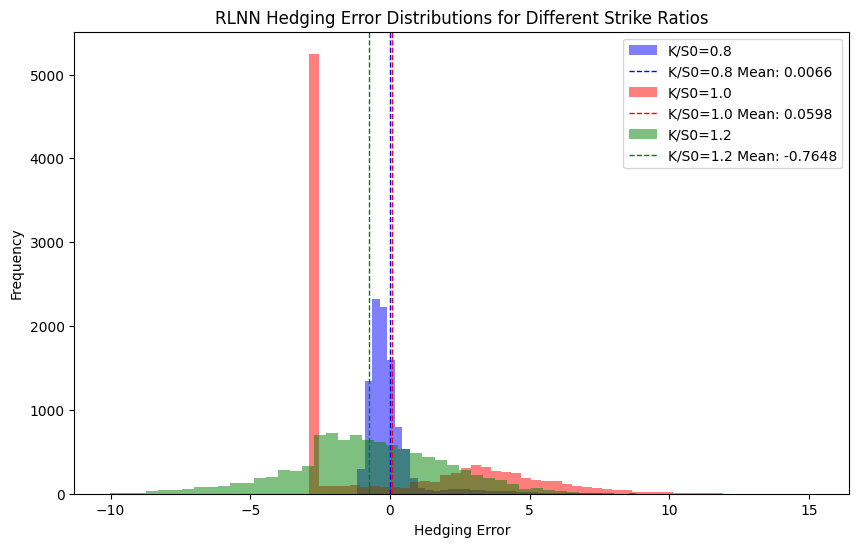

In [47]:

# Parameters
S0 = 50
K_values = [0.8 * S0, 1.0 * S0, 1.2 * S0]  # K = 40, 50, 60
r = 0.06     # Risk free rate
sigma = 0.2
T = 1
hedge_freq = 24
monitoring_dates = np.array([0.25, 0.5, 0.75, 1])
M = 10000

# Compute RLNN hedging errors for the three different strikes
hedging_error_80 = rlnn_hedge_error(S0, K_values[0], r, sigma, T, monitoring_dates, hedge_freq, M, sample_size= 10000)
hedging_error_100 = rlnn_hedge_error(S0, K_values[1], r, sigma, T, monitoring_dates, hedge_freq, M , sample_size= 10000)
hedging_error_120 = rlnn_hedge_error(S0, K_values[2], r, sigma, T, monitoring_dates, hedge_freq, M , sample_size= 10000)

# Plotting
plt.figure(figsize=(10,6))

plt.hist(hedging_error_80, bins=50, label='K/S0=0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label=f'K/S0=0.8 Mean: {np.mean(hedging_error_80):.4f}')

plt.hist(hedging_error_100, bins=50, label='K/S0=1.0', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error_100), color='r', linestyle='dashed', linewidth=1, label=f'K/S0=1.0 Mean: {np.mean(hedging_error_100):.4f}')

plt.hist(hedging_error_120, bins=50, label='K/S0=1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label=f'K/S0=1.2 Mean: {np.mean(hedging_error_120):.4f}')

plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.title('RLNN Hedging Error Distributions for Different Strike Ratios')
plt.legend()
plt.savefig('Hedge_error_RLNN_freq24_sample5000.jpeg')
plt.show()


In [43]:
hedging_error_100 = rlnn_hedge_error(S0, K_values[1], r, sigma, T, monitoring_dates, hedge_freq, M)

Running rlnn_hedge_error:
Parameters: 50 50.0 0.06 0.2 1 [0.25 0.5  0.75 1.  ] 24 5000 32 0.001 put
Running RLNN_Algo:
Parameters: 50 50.0 0.06 0.2 5000 4 1 put 32 0.001
Running stock_price_simulator:
Inputs: S0= 50 mu= 0.06 sigma= 0.2 T= 1 N= 4 M= 5000
stock_price_simulator output shape: (5000, 5)
stock_paths shape: (5000, 5)
option_price init shape: (5000, 5)
Computing payoff_fun:
Shapes: S: (5000,) K: 50.0 option_type: put
payoff_fun result shape: (5000,)
Computing payoff_fun:
Shapes: S: (5000,) K: 50.0 option_type: put
payoff_fun result shape: (5000,)
At maturity, option_price[:,N] shape: (5000,)
Pre-Training Neural Network...
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Pre-training complete.
X_train shape: (3500, 1) X_test shape: (1500, 1)
Creating shallow NN with input_dim = 1 and hidden_units = 32
Shallow NN model created.
Training for last monitoring date complete.
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Validation error for last date: 

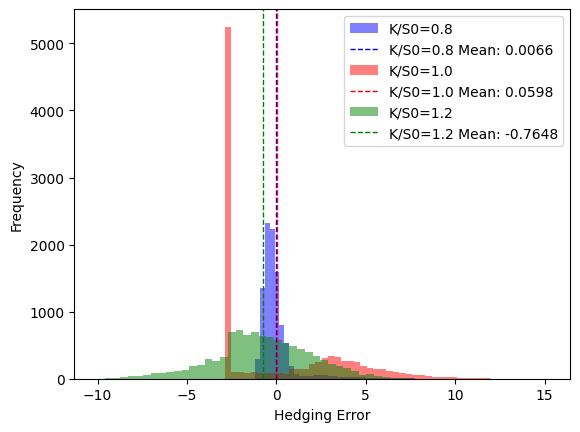

In [51]:

# Plotting
plt.figure()

plt.hist(hedging_error_80, bins=50, label='K/S0=0.8', color='b', alpha=0.5)
plt.axvline(np.mean(hedging_error_80), color='b', linestyle='dashed', linewidth=1, label=f'K/S0=0.8 Mean: {np.mean(hedging_error_80):.4f}')

plt.hist(hedging_error_100, bins=50, label='K/S0=1.0', color='r', alpha=0.5)
plt.axvline(np.mean(hedging_error_100), color='r', linestyle='dashed', linewidth=1, label=f'K/S0=1.0 Mean: {np.mean(hedging_error_100):.4f}')

plt.hist(hedging_error_120, bins=50, label='K/S0=1.2', color='g', alpha=0.5)
plt.axvline(np.mean(hedging_error_120), color='g', linestyle='dashed', linewidth=1, label=f'K/S0=1.2 Mean: {np.mean(hedging_error_120):.4f}')

plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
# plt.title('RLNN Hedging Error Distributions for Different Strike Ratios')
plt.legend()
plt.savefig('Hedge_error_RLNN_freq24_sample5000.jpeg')
plt.show()
